### Задание 1. Линейная регрессия (LinReg) и дисперсионный анализ (ANOVA)

In [64]:
!pip install seaborn scikit-learn statsmodels scipy

In [65]:
import numpy as np
import pandas as pd

import seaborn as sns              
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris  # загрузка датасета Iris
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm  # статистические модели
from scipy.stats import chi2

from itertools import combinations

from scipy import stats  # статистические тесты (ANOVA, корреляция)

import warnings
warnings.filterwarnings("ignore")  # отключаем предупреждения

[1] Выбрать один из датасетов из перечня:
- Iris
- Wine Quality
- Palmer Archipelago (Antarctica) penguin
- Любой другой датасет, в котором есть три класса и четыре количественных
(недискретных) признака.

In [66]:
# тянем датасет Iris из sklearn
iris = load_iris(as_frame=True) # загружаем датасет как pandas DataFrame

df = iris.frame  # получаем датафрейм (таблицу) с признаками и целевой переменной
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [67]:
# Добавляем имя класса (категория вида цветка) вместо числовой метки
df['target_name'] = df['target'].map(dict(enumerate(iris.target_names)))
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


[2] Вывести в табличной форме статистику по датасету, включая
- Размерность всего датасета
- Количество признаков
- Количество целевых классов и объектов в каждом из классов
- Процент объектов с неопределенными признаками
- Иные ключевые характеристики датасета
Выбрать три класса и четыре количественных (недискретных) признака.
Сформировать на их основе «отфильтрованный» датасет для дальнейшего анализа, удалив
из датасета все объекты, для которых не определены значения хотя бы одного из
выбранных четырех количественных признаков.

In [68]:
n_samples, n_features = df.shape   # количество объектов и признаков

feature_count = len(iris.feature_names)  # количество количественных признаков

class_counts = df['target_name'].value_counts()  # число элементов каждого класса

missing_percent = df.isna().mean().mean() * 100  # процент объектов с неопределенными признаками
# df.isna() -> таблица с true там где null -> mean по строке (доля пропусков) -> mean по столбцу -> среднее пропусков * 100

print("Размерность всего датасета:", (n_samples, n_features))
print("Количество признаков:", feature_count)
print("Количество целевых классов:", class_counts.shape[0])
print("Объектов в каждом классе:\n", class_counts)
print("Процент объектов с неопределенными признаками:", missing_percent)
print("Иные ключевые характеристики датасета:\n")
df.describe()

Размерность всего датасета: (150, 6)
Количество признаков: 4
Количество целевых классов: 3
Объектов в каждом классе:
 target_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64
Процент объектов с неопределенными признаками: 0.0
Иные ключевые характеристики датасета:



,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [69]:
# Отбираем 4 количественных признака и 3 класса для анализа
features = iris.feature_names              # все 4 признака
classes = iris.target_names                # все 3 класса

# Удаляем строки с пропусками (их нет в Iris, но оставим на будущее)
filtered_df = df.dropna(subset=features)   # удаляем объекты с NaN
filtered_df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


[3] Выполнить визуализацию датасета по всем парам выбранных количественных
переменных, обозначая:
- в графиках с разными парами переменных объекты из разных классов различными по
форме и цвету точками,
- в графиках с одной и той же парой переменных – гистограммы с достаточным числом
разбиений (обычно – не менее 20), либо плотности распределения переменной по оси
признака.

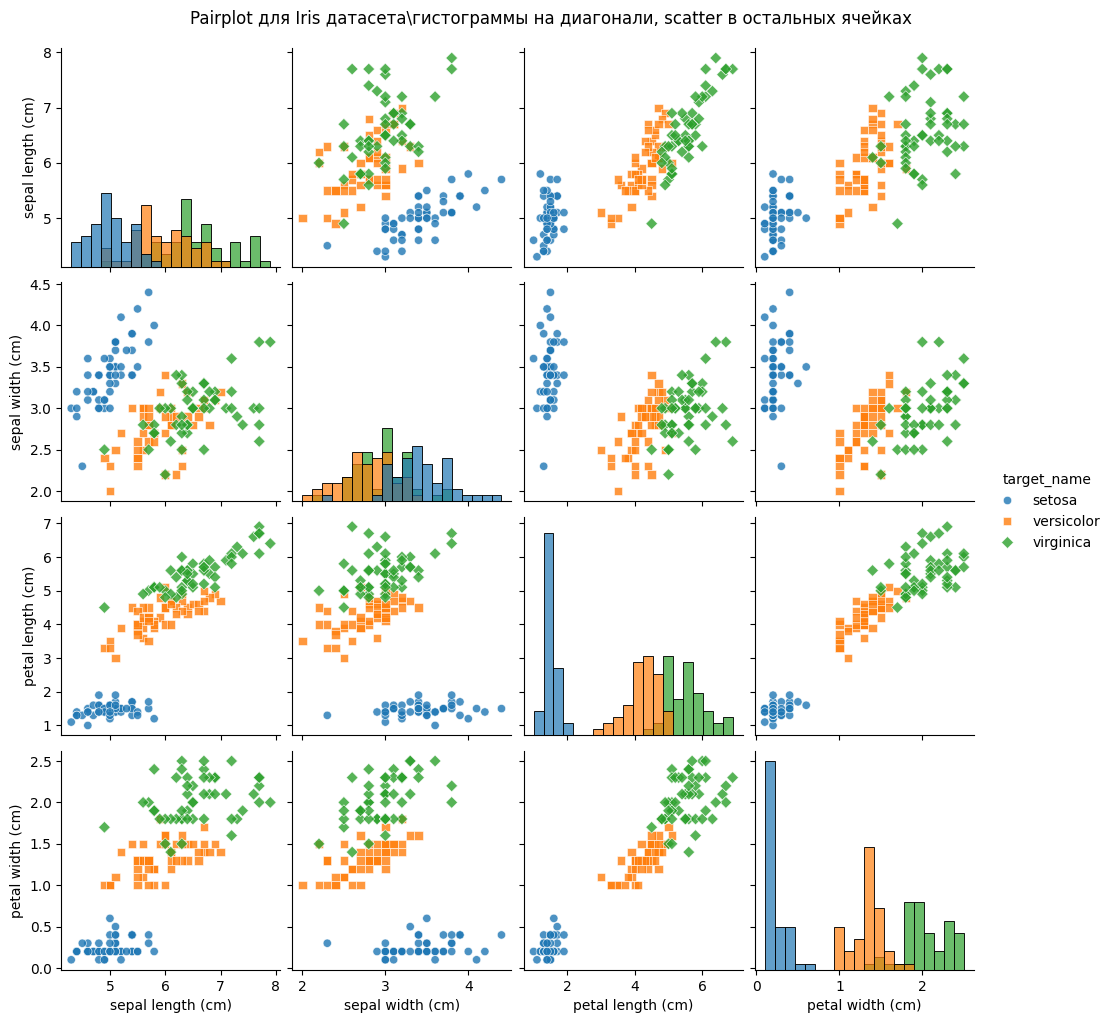

In [70]:
# Pairplot с цветом и формой точек по target_name
sns.pairplot(
    filtered_df,
    vars=features,
    hue="target_name",       # цвет по классу
    markers=["o", "s", "D"], # разные формы: кружок квадрат ромб
    diag_kind="hist",        # диагональ = гистограммы
    diag_kws={"bins": 20, "alpha": 0.7}, # 20 разбиений полупрозрачные
    plot_kws={"alpha": 0.8}  # прозрачность точек
)

plt.suptitle("Pairplot для Iris датасета\гистограммы на диагонали, scatter в остальных ячейках", y=1.02)
plt.show()

по диагонали
- отображены распределения каждого из параметров
- если распределения не пересекаются: признак сам по себе хорошо разделяет классы

вне диагонали
- каждая ячейка = комбинация двух разных признаков из датасета. каждая точка - один цветок из датасета
- если точки разных классов отдельны или почти не пересекаются значит комбинация этих двух признаков хорошо разделяет классы

[4] В табличном варианте оценить степень сопряженности пар признак-признак на всем
датасете, используя коэффициенты корреляции Пирсона и Спирмана, с p-критериями для
коэффициентов. В табличном варианте также оценить степень сопряженности пар признак-
признак в каждом отдельном классе, используя коэффициенты корреляции Пирсона и
Спирмана, с p-критериями для коэффициентов. Таблицы корреляций также отобразить как
тепловые карты.

### Коэффициент корреляции Пирсона

$$
r_{XY} = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \cdot \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$


* X_i, Y_i — значения признаков X и Y для объекта i
* $\bar{X}$, $\bar{Y}$ — средние значения признаков
* n — число объектов


- Пирсон показывает линейную зависимость между признаками.
- r $\approx$ 1 — сильная положительная линейная зависимость
- r $\approx$ -1 — сильная отрицательная линейная зависимость
- r $\approx$ 0 — линейной зависимости почти нет


### Коэффициент корреляции Спирмана (ранговый)

$$
\rho = 1 - \frac{6 \sum_{i=1}^{n} d_i^2}{n(n^2 - 1)}
$$
- $ d_i = R(X_i) - R(Y_i) $ — разница рангов значений признаков
- $ R(X_i), R(Y_i)$  — ранги значений X_i, Y_i
- ранги значений — порядковые номера элементов при их сортировке
- n — число объектов


- Спирман оценивает монотонную зависимость не обязательно линейную
- $\rho \approx$ 1 — сильная положительная монотонная зависимость
- $\rho \approx$ -1 — сильная отрицательная монотонная зависимость
- $\rho \approx$ 0 — монотонной зависимости почти нет

In [71]:
# функция для корреляций с p-value
def corr_matrix_with_p(df, method='pearson'):
    # создаем два DataFrame размером m×m где m - число признаков)
    # corr — для значений r
    # pvals — для p-значений
    corr = pd.DataFrame(np.zeros((len(features), len(features))), columns=features, index=features)
    pvals = pd.DataFrame(np.zeros((len(features), len(features))), columns=features, index=features)
    
    for i in features:
        for j in features:
            if method == 'pearson':
                # линейная корреляции (r) и p-value проверки H0 r=0
                r, p = stats.pearsonr(df[i], df[j])
            elif method == 'spearman':
                # ранговая монтоническая корреляция и её p-value
                r, p = stats.spearmanr(df[i], df[j])
            else:
                raise ValueError("method must be 'pearson' or 'spearman'")
            
            # Сохраняет r и p в соответствующие ячейки матриц
            corr.loc[i, j] = r
            pvals.loc[i, j] = p
    return corr, pvals

# Визуализация тепловых карт | несколько тепловых карт на одной картинке
def plot_heatmaps(corrs, titles, ncols=2, figsize=(10, 5)):
    n = len(corrs)
    nrows = (n + ncols - 1) // ncols  # количество строк

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # axes может быть матрицей или массивом тогда --> разворачиваем в список
    axes = axes.flatten() if n > 1 else [axes]

    for i, (corr, title) in enumerate(zip(corrs, titles)):
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
                    vmin=-1, vmax=1, ax=axes[i])
        axes[i].set_title(title)

    # убрать пустые оси если их больше чем нужно
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [72]:
# Корреляции по всему датасету
pearson_corr, pearson_p = corr_matrix_with_p(df, method='pearson')
spearman_corr, spearman_p = corr_matrix_with_p(df, method='spearman')

# Корреляции по каждому классу
class_corrs = {}
for cls in df['target_name'].unique():
    class_df = df[df['target_name'] == cls]
    class_corrs[cls] = {
        'pearson': corr_matrix_with_p(class_df, method='pearson'),
        'spearman': corr_matrix_with_p(class_df, method='spearman')
    }

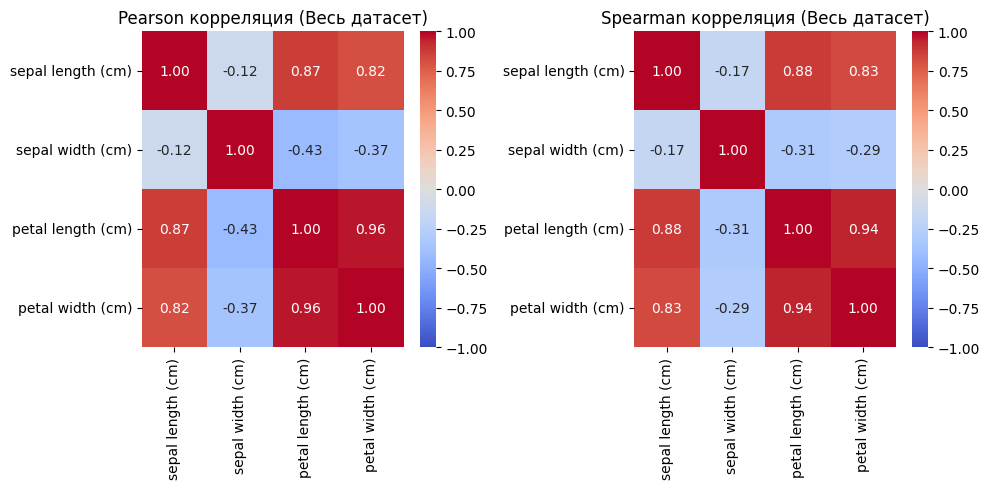

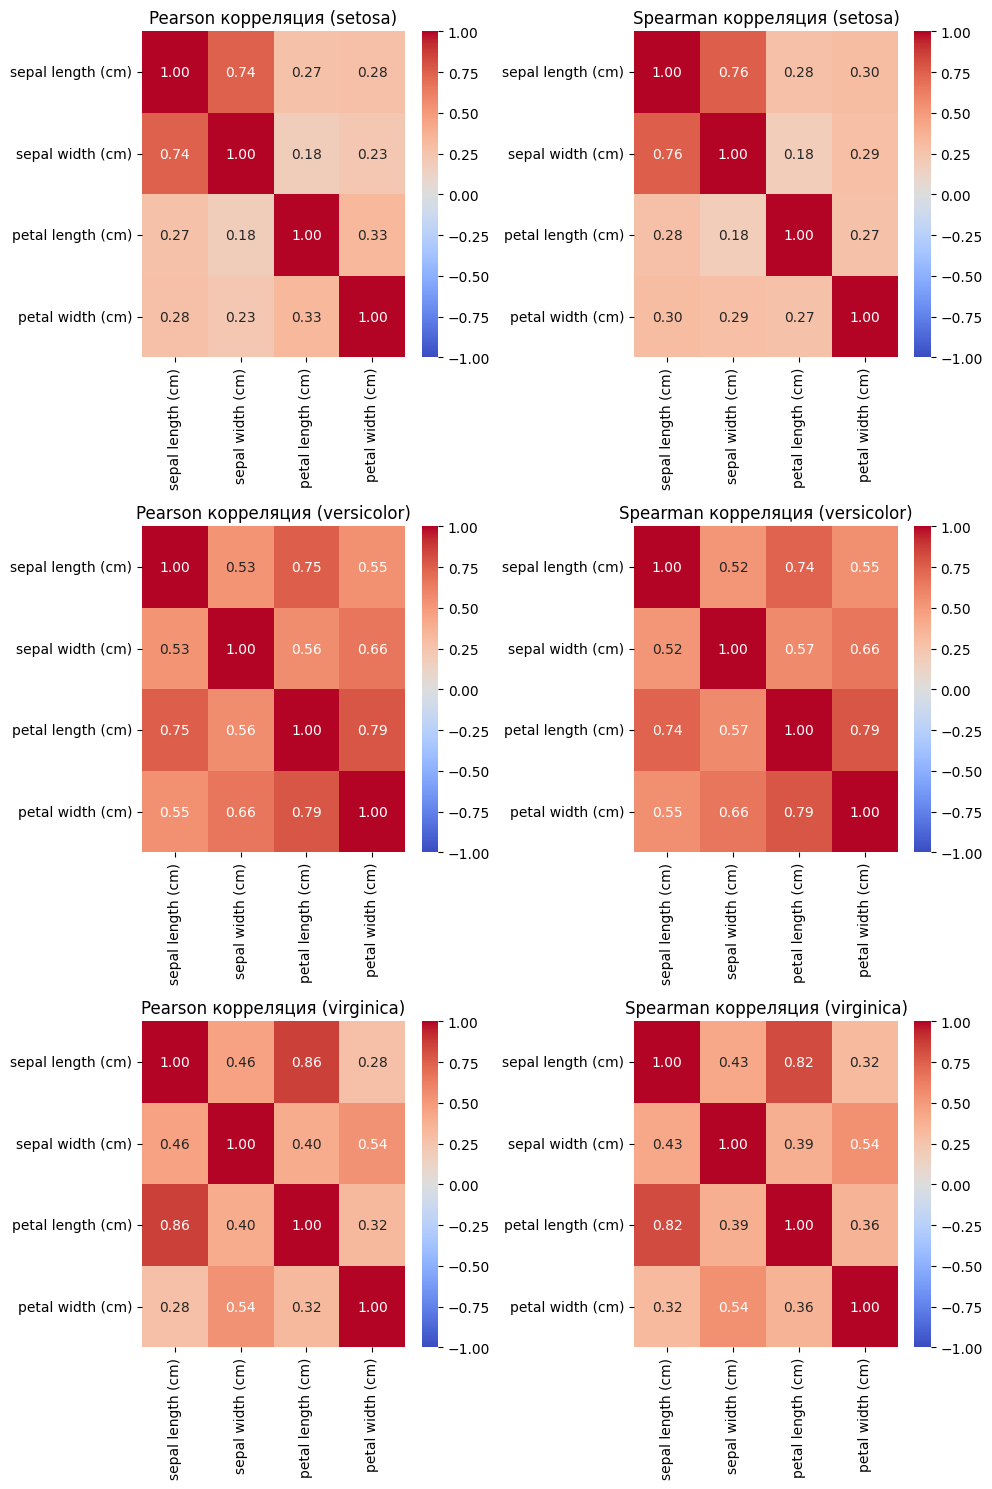

Pearson p-values (Весь датасет):
                    sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)       0.000000e+00      1.518983e-01       1.038667e-47   
sepal width (cm)        1.518983e-01      0.000000e+00       4.513314e-08   
petal length (cm)       1.038667e-47      4.513314e-08       0.000000e+00   
petal width (cm)        2.325498e-37      4.073229e-06       4.675004e-86   

                   petal width (cm)  
sepal length (cm)      2.325498e-37  
sepal width (cm)       4.073229e-06  
petal length (cm)      4.675004e-86  
petal width (cm)       0.000000e+00  
Spearman p-values (Весь датасет):
                    sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)       0.000000e+00          0.041368       3.443087e-50   
sepal width (cm)        4.136799e-02          0.000000       1.153938e-04   
petal length (cm)       3.443087e-50          0.000115       0.000000e+00   
petal width (cm)        4.189447e-40          0

In [82]:
plot_heatmaps([pearson_corr, spearman_corr], ["Pearson корреляция (Весь датасет)", "Spearman корреляция (Весь датасет)"], ncols=2, figsize=(10,5))

mtrxs = []
names = []

for cls in df['target_name'].unique():
    mtrxs.append(class_corrs[cls]['pearson'][0])
    names.append(f"Pearson корреляция ({cls})")

    mtrxs.append(class_corrs[cls]['spearman'][0])
    names.append(f"Spearman корреляция ({cls})")

plot_heatmaps(mtrxs, names ,ncols=2, figsize=(10,15))

# Табличный вывод p-values
print("Pearson p-values (Весь датасет):\n", pearson_p)
print("Spearman p-values (Весь датасет):\n", spearman_p)

H0: между признаками i и j нет линейной корреляции (ρ = 0)
1.518983e-01 ~= 0.15 => линейной корреялиции нет (cвязь не статистически значим)
а в случае 8.156597e-70 => сильная линейная корреляция
пары с низким p-value => линейно зависимы => один из признаков может быть предсказателем другого

[5] Отдельно повторно выполнить пункт [3]; на каждом из графиков для каждого из классов
отобразить линию линейной регрессии с соответствующими прогнозными интервалами
регрессий (95% predictive bands).

Predictive bands показывают диапазон в котором с вероятностью 95% будут лежать новые наблюдения

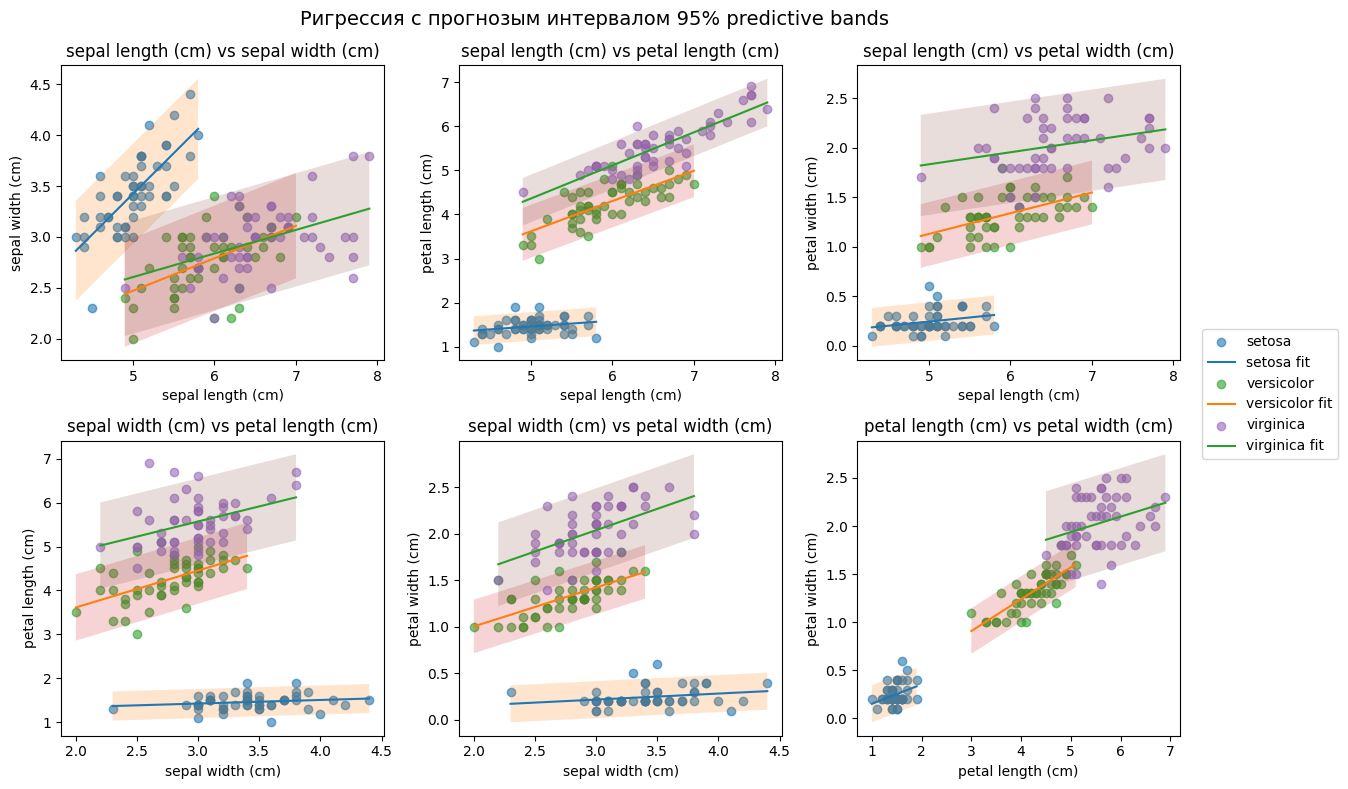

In [74]:
def plot_with_predictive_bands(df, features, target_col="target_name"):
    n = len(features)
    pairs = [(i, j) for i in range(n) for j in range(i+1, n)]
    nplots = len(pairs)

    ncols = int(np.ceil(np.sqrt(nplots)))
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharex=False, sharey=False)
    axes = axes.flatten()

    for ax, (i, j) in zip(axes, pairs):
        x, y = features[i], features[j]

        if i >= j:
                continue  # только верхний треугольник чтобы не дублировать графики для пар признаков

        for cls, cls_df in df.groupby(target_col):
            X = cls_df[[x]].values
            Y = cls_df[y].values

            # Линейная регрессия
            model = LinearRegression().fit(X, Y)
            x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
            y_pred = model.predict(x_vals)
            # x_vals — равномерная сетка по оси x для построения линии регрессии
	        # y_pred — предсказанные значения y по линии регрессии


            # Оценка стандартного отклонения остатков
            residuals = Y - model.predict(X)
            sigma = residuals.std()  # стандартное отклонение остатков

            # Predictive bands (95%)
            y_lower = y_pred - 1.96 * sigma
            y_upper = y_pred + 1.96 * sigma

            ax.scatter(X, Y, alpha=0.6, label=f"{cls}")
            ax.plot(x_vals, y_pred, label=f"{cls} fit")
            ax.fill_between(x_vals.ravel(), y_lower, y_upper, alpha=0.2)

        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(f"{x} vs {y}")

    # легенда справа
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))

    fig.suptitle("Ригрессия с прогнозым интервалом 95% predictive bands", fontsize=14)

    # двигаем содержимое влево чтобы освободить место под легенду
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

plot_with_predictive_bands(filtered_df, features)

[6] Повторить пункт [5], но с доверительными интервалами регрессий (95% confidence
bands).

Confidence bands показывают диапазон в котором с вероятностью 95% лежит истинная регрессионная линия.
Эти интервалы уже чем в Predictive bands 

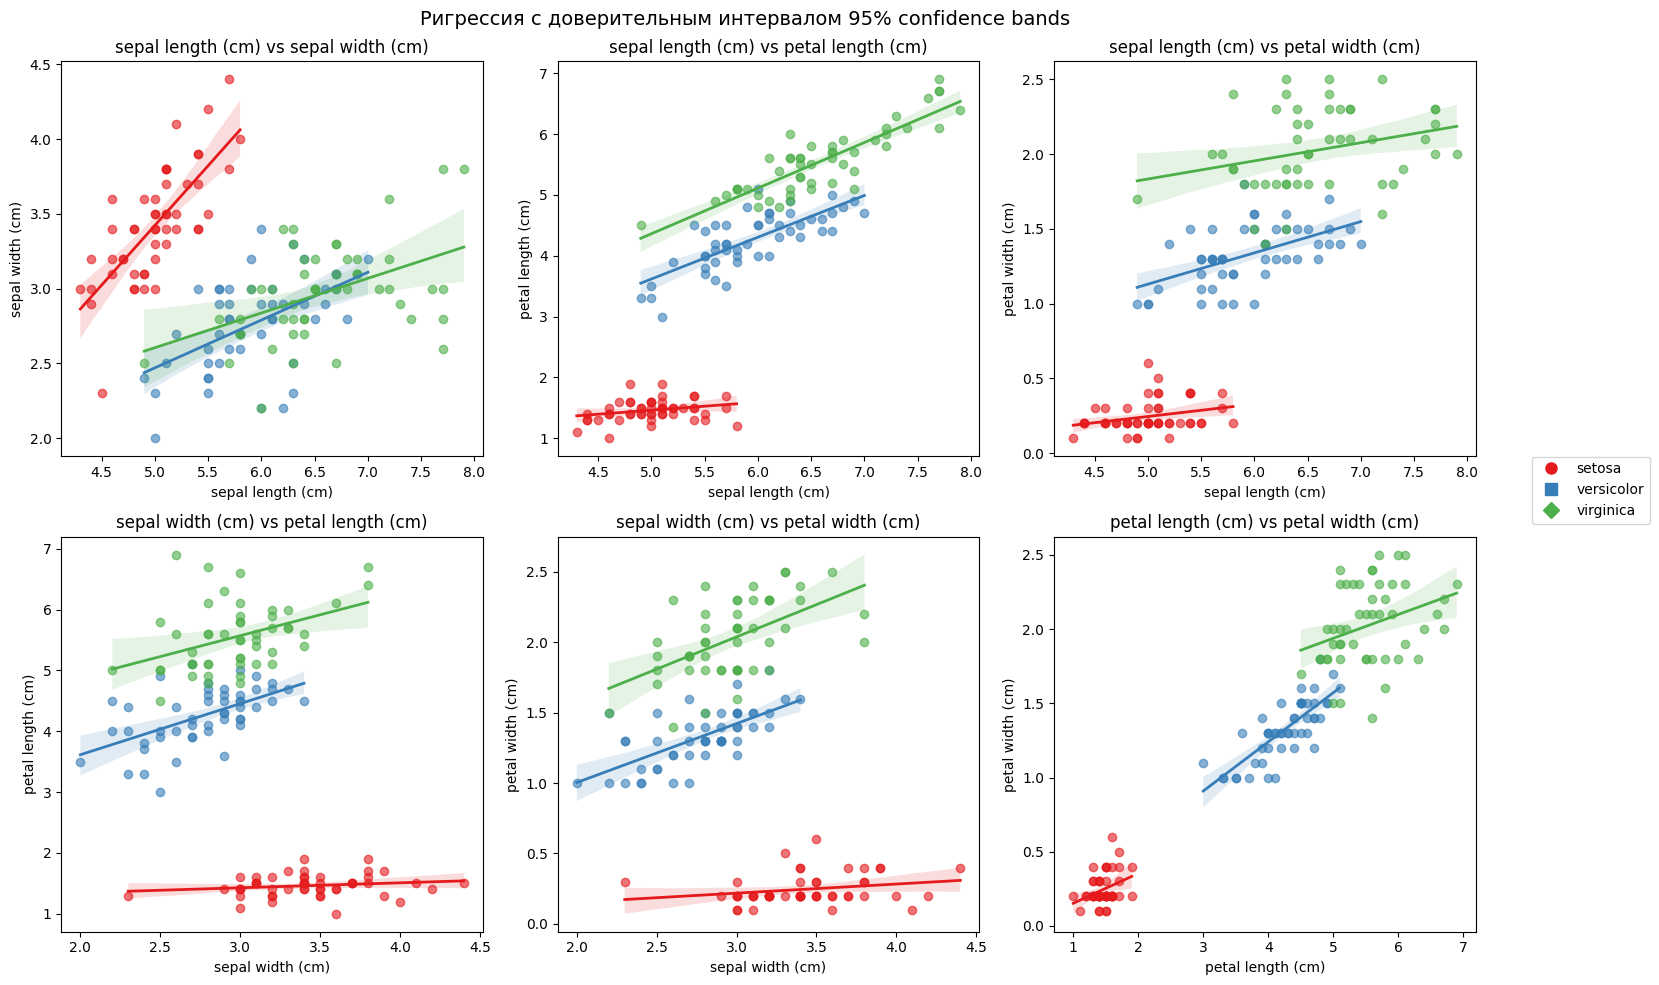

In [75]:
# в seaborn lmplot автоматически строит линрег y = B0 + B1 * x чтобы минимизировать MSE
# seaborn использует бутстрэп (по умолчанию 1000 выборок), чтобы оценить разброс коэффициентов B0 и B1
# seaborn по умолчанию строит доверительные интервалы а не предиктивные
def plot_confidence_bands_on_one_figure(df, features, target_col="target_name"):
    n = len(features)
    pairs = [(i, j) for i in range(n) for j in range(n) if i < j]
    nplots = len(pairs)

    ncols = min(3, int(np.ceil(nplots**0.5)))
    nrows = int(np.ceil(nplots / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()

    palette = sns.color_palette("Set1", df[target_col].nunique())
    markers = ["o", "s", "D"]
    class_styles = {cls: {"color": palette[i], "marker": markers[i % len(markers)]}
                    for i, cls in enumerate(df[target_col].unique())}

    for ax, (i, j) in zip(axes, pairs):
        x, y = features[i], features[j]

        for cls, cls_df in df.groupby(target_col):
            sns.regplot(
                data=cls_df,
                x=x,
                y=y,
                ci=95, # 95% confidence interval
                ax=ax,
                scatter_kws={"alpha":0.6, "marker": class_styles[cls]["marker"], "color": class_styles[cls]["color"]},
                line_kws={"color": class_styles[cls]["color"], "lw":2}
            )

        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(f"{x} vs {y}")

    # общая легенда
    handles = [plt.Line2D([0],[0], marker=class_styles[cls]["marker"], color=class_styles[cls]["color"], linestyle='',
                          markersize=8) for cls in df[target_col].unique()]
    labels = df[target_col].unique()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5))

    fig.suptitle("Ригрессия с доверительным интервалом 95% confidence bands", fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

plot_confidence_bands_on_one_figure(filtered_df, features)

[7] Вывести формулы каждой линейной регрессии вместе со значениями критерия R2
,
критерия Вальда (F-критерий, его степени свободы и соответствующий p-критерий),
критерия LR (хи-квадрат-критерий, степени свободы и соответствующий p-критерий),
критерия score (хи-квадрат-критерий, степени свободы и соответствующий p-критерий).

Формула регрессии: 
* B0 свободный член (intercept), значение y, когда x = 0 
* B1 — коэффициент при x (slope), показывает, насколько изменяется y при увеличении x на единицу.

R² коэффициент детерминации:
* показывает какая доля вариации зависимой переменной y объясняется независимой переменной x
* значеник 0 → x почти не объясняет y | 1 → x полностью объясняет y
* 0–0.3 → слабая зависимость
* 0.3–0.6 → умеренная
* 0.6–1 → сильная

F-статистика критерий Вальда
* проверяет гипотезу все коэффициенты модели равны нулю (модель не имеет предсказательной силы)
* высокое значение F → модель значима
* смотрим также p(F):
  * p < 0.05 → отклоняем нулевую гипотезу, модель значимо предсказывает y
  * p ≥ 0.05 → модель незначима.

LR-тест Likelihood Ratio, χ²
* сравнивает полную модель с нулевой моделью (только константа)
* LR χ² высокая → модель значительно лучше, чем нулевая
* df(LR) = число коэффициентов, которые проверяем
* p(LR):
  * p < 0.05 → модель значительно улучшает объяснение y

Score-тест χ²
* Альтернатива LR-тесту, проверяет значимость коэффициентов
* Для одной переменной часто равносилен t² из OLS
* p(Score) < 0.05 → коэффициент при x значимо отличается от нуля

In [76]:
results = []

# Перебор всех пар признаков X → Y
for x_var in features:
    for y_var in features:
        if x_var == y_var:  # нет смысла строить регрессию признака на самого себя
            continue

        for cls in filtered_df['target_name'].unique():
            df_class = filtered_df[filtered_df['target_name'] == cls]

            # независимая переменная с добавленной константой (столбец “1” для свободного члена b_0)
            X = sm.add_constant(df_class[x_var])
            y = df_class[y_var]

            # OLS для R² и F-критерия (Вальда)
            ols_model = sm.OLS(y, X).fit()

            # GLM для LR и Score
            glm_model = sm.GLM(y, X, family=sm.families.Gaussian()).fit()

            # LR-тест: нулевая модель только с константой
            null_X = pd.DataFrame({'const': 1}, index=y.index)  # константа с правильными индексами
            null_model = sm.GLM(y, null_X, family=sm.families.Gaussian()).fit()

            # LR-статистика
            lr_stat = 2 * (glm_model.llf - null_model.llf)
            lr_df = int(glm_model.df_model)
            from scipy.stats import chi2
            lr_pvalue = chi2.sf(lr_stat, lr_df)

            score_stat = ols_model.tvalues.iloc[1]**2   # t^2 ≈ χ² с df=1
            score_df = 1
            score_pval = ols_model.pvalues.iloc[1]      # p-value для коэффициента

            results.append({
                "Класс": cls,
                "Регрессия": f"{y_var} = {ols_model.params.iloc[0]:.3f} + {ols_model.params.iloc[1]:.3f} * {x_var}",
                "R²": ols_model.rsquared,
                "F-статистика (Вальда)": ols_model.fvalue,
                "df (числитель)": int(ols_model.df_model),
                "df (знаменатель)": int(ols_model.df_resid),
                "p(F)": ols_model.f_pvalue,
                "LR тест (χ²)": lr_stat,
                "df (LR)": lr_df,
                "p(LR)": lr_pvalue,
                "Score тест (χ²)": score_stat,
                "df (Score)": int(score_df),
                "p(Score)": score_pval
            })

# Таблица результатов
regression_results = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
regression_results

,Класс,Регрессия,R²,F-статистика (Вальда),df (числитель),df (знаменатель),p(F),LR тест (χ²),df (LR),p(LR),Score тест (χ²),df (Score),p(Score)
0,setosa,sepal width (cm) = -0.569 + 0.799 * sepal length (cm),0.551376,58.993730,1,48,6.709843e-10,40.078461,1,2.439642e-10,58.993730,1,6.709843e-10
1,versicolor,sepal width (cm) = 0.872 + 0.320 * sepal length (cm),0.276582,18.351688,1,48,8.771860e-05,16.188410,1,5.734390e-05,18.351688,1,8.771860e-05
2,virginica,sepal width (cm) = 1.446 + 0.232 * sepal length (cm),0.209057,12.687074,1,48,8.434625e-04,11.726486,1,6.161682e-04,12.687074,1,8.434625e-04
3,setosa,petal length (cm) = 0.803 + 0.132 * sepal length (cm),0.071383,3.689765,1,48,6.069778e-02,3.702939,1,5.431672e-02,3.689765,1,6.069778e-02
4,versicolor,petal length (cm) = 0.185 + 0.686 * sepal length (cm),0.568590,63.263024,1,48,2.586190e-10,42.034799,1,8.966350e-11,63.263024,1,2.586190e-10
5,virginica,petal length (cm) = 0.610 + 0.750 * sepal length (cm),0.746884,141.636664,1,48,6.297786e-16,68.695447,1,1.149059e-16,141.636664,1,6.297786e-16
6,setosa,petal width (cm) = -0.170 + 0.083 * sepal length (cm),0.077339,4.023424,1,48,5.052644e-02,4.024653,1,4.483984e-02,4.023424,1,5.052644e-02
7,versicolor,petal width (cm) = 0.083 + 0.209 * sepal length (cm),0.298620,20.436482,1,48,4.035422e-05,17.735252,1,2.538781e-05,20.436482,1,4.035422e-05
8,virginica,petal width (cm) = 1.226 + 0.121 * sepal length (cm),0.079022,4.118483,1,48,4.798149e-02,4.115932,1,4.248112e-02,4.118483,1,4.798149e-02
9,setosa,sepal length (cm) = 2.639 + 0.690 * sepal width (cm),0.551376,58.993730,1,48,6.709843e-10,40.078461,1,2.439642e-10,58.993730,1,6.709843e-10


[8] Выбрать любой количественный признак и выполнить дисперсионный анализ (ANOVA):
- Рассчитать F-критерий, его степени свободы и соответствующий ему p-критерий для
всех классов одновременно;
- Рассчитать F-критерий, степени свободы и соответствующий ему p-критерий для каждой
пары сравниваемых классов;
- Визуализировать выбранный количественный признак для каждого из классов в виде
raincloud plot with jittering, рядом с каждым классом в виде boxplot отобразить медианы,
межквартильные размахи (IQR) и 95% доверительные интервалы.

In [77]:
# ANOVA для всех классов одновременно
feature = 'sepal length (cm)'  # выбираем признак

# Группируем данные по классам
groups = [df[df['target_name'] == cls][feature] for cls in df['target_name'].unique()]

# Однофакторный ANOVA
f_stat, p_value = stats.f_oneway(*groups)
df_between = len(groups) - 1
df_within = len(df) - len(groups)

print(f"ANOVA (все классы): F = {f_stat:.3f}, df_between = {df_between}, df_within = {df_within}, p = {p_value:.3f}")

ANOVA (все классы): F = 119.265, df_between = 2, df_within = 147, p = 0.000


In [78]:
from itertools import combinations

for cls1, cls2 in combinations(df['target_name'].unique(), 2):
    group1 = df[df['target_name'] == cls1][feature]
    group2 = df[df['target_name'] == cls2][feature]
    f_stat_pair, p_value_pair = stats.f_oneway(group1, group2)
    print(f"{cls1} vs {cls2}: F = {f_stat_pair:.3f}, df_between = 1, df_within = {len(group1)+len(group2)-2}, p = {p_value_pair:.3f}")

setosa vs versicolor: F = 110.691, df_between = 1, df_within = 98, p = 0.000
setosa vs virginica: F = 236.735, df_between = 1, df_within = 98, p = 0.000
versicolor vs virginica: F = 31.688, df_between = 1, df_within = 98, p = 0.000


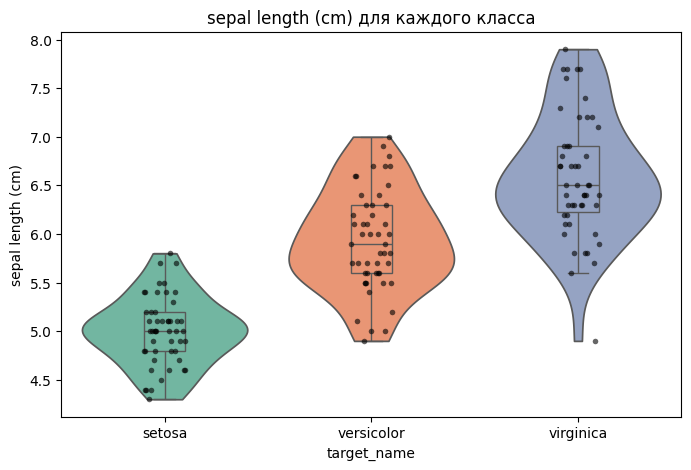

In [79]:
feature = 'sepal length (cm)'

plt.figure(figsize=(8,5))
sns.violinplot(x='target_name', y=feature, data=df, inner=None, palette="Set2", cut=0)
sns.stripplot(x='target_name', y=feature, data=df, color='k', size=4, jitter=True, alpha=0.6)
sns.boxplot(x='target_name', y=feature, data=df, whis=1.5, width=0.2, palette="Set2", fliersize=0, showcaps=True, boxprops={'facecolor':'None'})
plt.title(f'{feature} для каждого класса')
plt.show()

[9] Повторить пункт [8] для каждого отдельного из остальных трех признаков.


ANOVA для sepal width (cm)
F = 49.160, df_between = 2, df_within = 147, p = 0.000
setosa vs versicolor: F = 89.397, df_between = 1, df_within = 98, p = 0.000
setosa vs virginica: F = 41.607, df_between = 1, df_within = 98, p = 0.000
versicolor vs virginica: F = 10.277, df_between = 1, df_within = 98, p = 0.002

ANOVA для petal length (cm)
F = 1180.161, df_between = 2, df_within = 147, p = 0.000
setosa vs versicolor: F = 1559.675, df_between = 1, df_within = 98, p = 0.000
setosa vs virginica: F = 2498.619, df_between = 1, df_within = 98, p = 0.000
versicolor vs virginica: F = 158.855, df_between = 1, df_within = 98, p = 0.000

ANOVA для petal width (cm)
F = 960.007, df_between = 2, df_within = 147, p = 0.000
setosa vs versicolor: F = 1161.470, df_between = 1, df_within = 98, p = 0.000
setosa vs virginica: F = 1830.624, df_between = 1, df_within = 98, p = 0.000
versicolor vs virginica: F = 213.901, df_between = 1, df_within = 98, p = 0.000


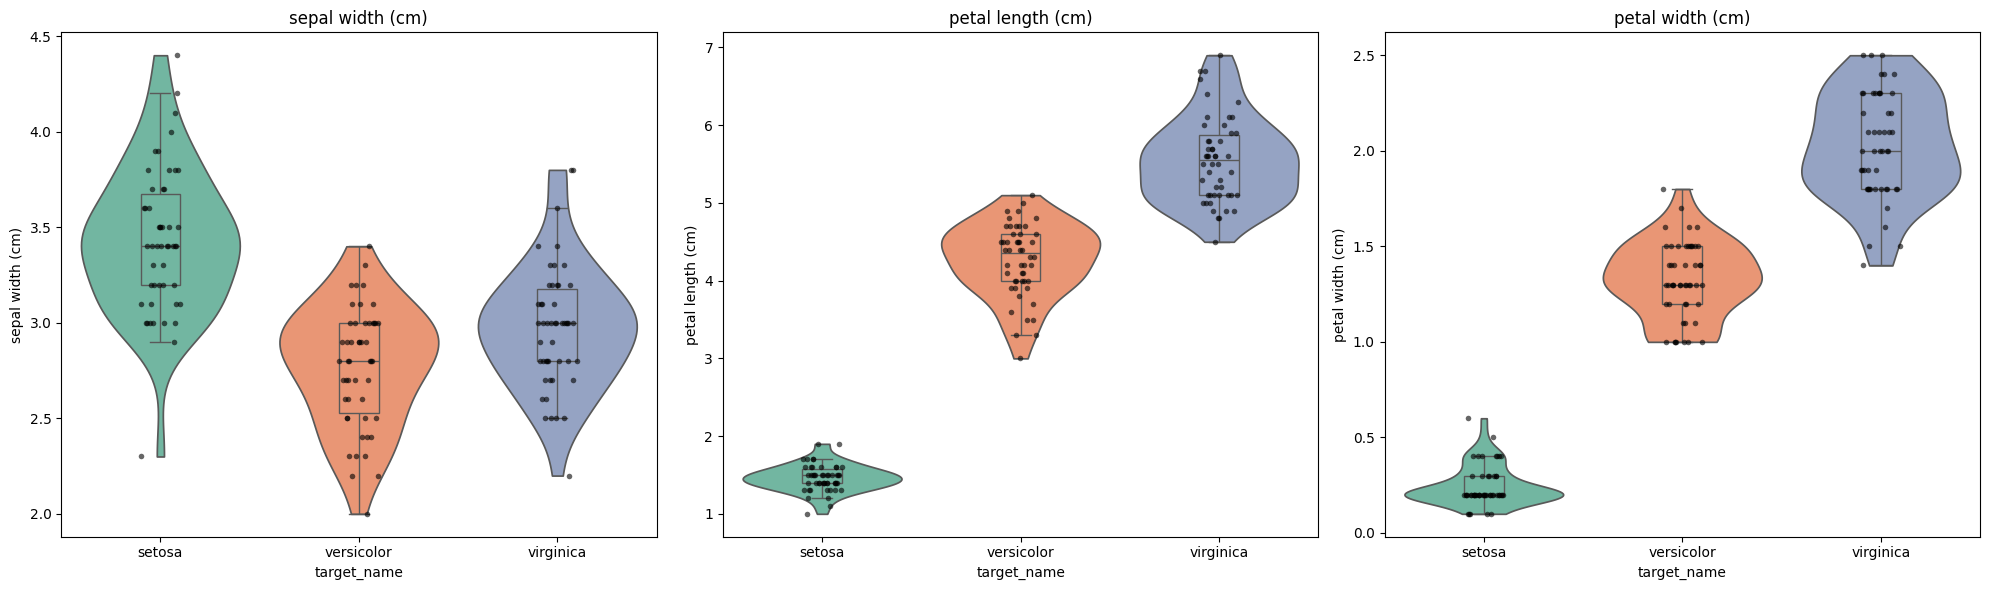

In [80]:
features = ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

# Создаём фигуру с подграфиками
fig, axes = plt.subplots(1, len(features), figsize=(20,6))

for i, feature in enumerate(features):
    ax = axes[i]
    
    # ANOVA для всех классов
    groups = [df[df['target_name'] == cls][feature] for cls in df['target_name'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    df_between = len(groups) - 1
    df_within = len(df) - len(groups)
    print(f"\nANOVA для {feature}")
    print(f"F = {f_stat:.3f}, df_between = {df_between}, df_within = {df_within}, p = {p_value:.3f}")
    
    # ANOVA для каждой пары классов
    for cls1, cls2 in combinations(df['target_name'].unique(), 2):
        group1 = df[df['target_name'] == cls1][feature]
        group2 = df[df['target_name'] == cls2][feature]
        f_stat_pair, p_value_pair = stats.f_oneway(group1, group2)
        print(f"{cls1} vs {cls2}: F = {f_stat_pair:.3f}, df_between = 1, df_within = {len(group1)+len(group2)-2}, p = {p_value_pair:.3f}")
    
    # Визуализация на подграфике
    sns.violinplot(x='target_name', y=feature, data=df, inner=None, palette="Set2", cut=0, ax=ax)
    sns.stripplot(x='target_name', y=feature, data=df, color='k', size=4, jitter=True, alpha=0.6, ax=ax)
    sns.boxplot(x='target_name', y=feature, data=df, whis=1.5, width=0.2, palette="Set2", fliersize=0, showcaps=True,
                boxprops={'facecolor':'None'}, ax=ax)
    ax.set_title(feature)

plt.tight_layout()
plt.show()